Time spent on this whole task start to finish: ~11 hours

I would have spent more, but I've got a full-time job (and I work weekends as well). 

What have I done?

Research phase: Read articles such as DeepSDF (which I ended up implementing here), Deformable Shape Completion with Graph Convolutional Autoencoders (comprehending meshes as graph data and defining convolution on graphs can be very helpful, but training a convolutional neural network for this approximation would have taken much more time), Occupancy Networks: Learning 3D Reconstruction in Function Space, Fully Convolutional Geometric Features, 3D Point Capsule Networks, MeshNet: Mesh Neural Network for 3D Shape Representation. General research on the topic, reading these papers and testing out the code that some of the papers provide took me one day, that day I also set up the environment and selected an approach (DeepSDF).

Development: In DeepSDF paper the model architecture was given in a very clear way: 8 ( provides a good tradeoff between
speed and accuracy) or 16 (produces smaller training error and higher accuracy on sume tasks) fully connected layers, ReLU activation, dropout rate - 0.3, MSE with delta boundary for loss, delta ~ 0.01, learning rate 1e-3 to 1e-5. 

Implementation: I tried both 8 and 16 layer architecture, with one small experiment with a network for learning 2D shapes that has only one hidden layer to make sure that the erchitecture works. 

Stumbling blocks: While kaolin sdf function was generally very slow (maybe due to some issues with compatibility), the mesh-t-sdf library produces much faster results, however, it had some bugs. One of the worst ones being defining sdf less than 0 for points far from the plain (you can see it play out in the last experiment at the end of the notebook). Also, the training samples influenced training in a drastic manner. I tried different sampling methods: the first sampling methid came directly from the paper: sampling "noisy" points in a delta+offset regeon near mesh border. This approach produced an imbalanced training dataset which resulted in worse results. Second sampling methos was to sample points near surface (samping with mesh-to-sdf buil in near surface sampling method) the dataset came out much more balanced< but the model fained to learch the negative sdf. The final methid that worked out for me was just randomly sampling 1 million points evenly distributed throughout the surface. The mesh-to-sdf bug has inluenced the training drastically in this sampling method, but assuming it is fixed - the actuall mesh was approximated pretty well. 

Next steps: If it was an actual task at my job and I had a proper amount of time to comlete it I would train a multi-class network using DeepSDF encoder-decoder architecture. I will provide the code for encoder and decoder models here:




```

class Decoder(nn.Module):
    def __init__(self, image_size=784, z_dim=2, data_shape=60000):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True), nn.Linear(512, 28 * 28), nn.Tanh())
        
        self.latent_vectors = nn.Parameter(torch.FloatTensor(data_shape, z_dim))
        
        init.xavier_normal(self.latent_vectors)
    
    def forward(self, ind):
        x = self.latent_vectors[ind]
        return self.decoder(x)
    
    def predict(self, x):
        return self.decoder(x)```

class Decoder(nn.Module):
    def __init__(self, z_dim=256, data_shape=200):
        super(Decoder, self).__init__()
        self.decoder_stage1 = nn.Sequential(
            nn.Linear(z_dim+3, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 253))
        
        self.decoder_stage2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 1),
            nn.Tanh())
        
        self.latent_vectors = nn.Parameter(torch.FloatTensor(data_shape, z_dim))
        
        init.xavier_normal(self.latent_vectors)
    
    def forward(self, ind, x):
        code = self.latent_vectors[ind].repeat(x.shape[0], 1)
        data = torch.cat((code, x), dim=1)
        decoder_stage1_out = self.decoder_stage1(data)
        data = torch.cat((decoder_stage1_out, data), dim=1)
        decoder_stage2_out = self.decoder_stage2(data)
        return decoder_stage2_out
    
    def codes(self):
        return self.latent_vectors

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
```
Also definitely sdf-sampling should be improved and more negative samples are needed. Ideally I would train to models using random evenly distributed dataset that produced good negative sdf predictions and using mesh-to-sdf near surface sampling that produced good positive sdf results. These two models combined would help generate a nice training dataset and using this dataset I would train a final model. I have tried different hyperparameters, losses and architecture variations and I would definitely continue trying more to grow understanding of how they influence the result. Also with more time I would try different representations and approaches like the ones suggested in mentioned papers.

I was also asked about using the transformer architecture for this task. I would probably not start this task by trying transformers, however, this architecture can be used in other 3d machine learning task such as: 3D object detection, use case: Spatiotemporal Transformer used to aggregatethe  spatiotemporal  information,  which  enhances  the  conventional ConvGRU with an attentive memory gating mechanism. Implemented and described in "LiDAR-based Online 3D Video Object Detection with Graph-based MessagePassing and Spatiotemporal Transformer Attention" paper. We can also use transformers in Graph neural networks such as SuperGlue approach: SuperGlue borrows theself-attention  from  the  Transformer,  but  embeds  it  into  agraph neural network, and additionally introduces the cross-attention, which is symmetric. This simplifies the architec-ture and results in better feature reuse across layers. Single image 3d reconstruction also employ sequence-to-sequence transformer architectures with attentions. 

In [ ]:
!pip install trimesh
!pip install  matplotlib==2.2.5  tqdm==4.32.1  pillow==6.2.2 imgaug==0.2.6
!pip install nuscenes-devkit
!pip install git+https://github.com/NVIDIAGameWorks/kaolin.git

In [ ]:
import kaolin as kal
import torch
import trimesh
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import trimesh
import numpy as np
import shutil
import os
from tqdm import tqdm_notebook as tqdm
import warnings
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

warnings.filterwarnings('ignore')

In [ ]:
print(kal.__version__)

0.1.0


In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/'My Drive'/3drender

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/3drender


In [ ]:
mesh = kal.rep.TriangleMesh.from_obj('3dobjects/1_simplified.obj')
sdf = kal.conversions.trianglemesh_to_sdf(mesh)
points = torch.rand(100,3)
distances = sdf(points)

In [ ]:
distances

tensor([ 1.9862e-03,  1.2321e+00,  2.8989e-01,  1.0403e-02,  5.5019e-01,
         4.3068e-01,  3.7365e-01,  8.2149e-01,  6.9030e-02,  4.5131e-01,
         1.7904e-01,  5.3036e-01,  5.1494e-01,  1.4124e-02,  8.5272e-01,
         1.0344e+00,  2.1116e-01,  2.0389e-01,  4.7171e-01,  2.0168e-01,
         8.7171e-02,  2.3960e-01,  4.2335e-01,  2.9848e-01,  4.5330e-02,
         2.5520e-01,  2.7630e-04,  7.5942e-01,  1.7891e-01,  5.5031e-03,
         2.1007e-01,  1.9321e-01,  7.7239e-01,  2.1267e-01,  4.0700e-01,
         8.1159e-01,  3.1129e-01,  6.3336e-01,  2.5844e-01,  3.4986e-01,
         3.0886e-01,  3.4736e-01,  1.6382e-01,  1.5765e-01,  3.6074e-01,
         2.8638e-01,  7.0139e-02,  2.6913e-01,  2.4030e-01,  3.0390e-01,
         3.8204e-01,  1.6759e-01,  2.3177e-01,  3.2258e-01,  4.5890e-01,
         8.9128e-03,  3.4584e-01,  4.5684e-01,  4.3050e-02,  1.2916e+00,
         1.1104e+00,  1.2422e-01,  9.4481e-01, -5.1647e-05,  5.7548e-01,
         9.2757e-01,  1.5283e-01,  7.8836e-02,  8.9

In [ ]:
mesh = trimesh.load('3dobjects/0_simplified.obj')
light = trimesh.scene.lighting.DirectionalLight()
light.intensity = 10
scene = trimesh.Scene([mesh], lights=[light])
scene.show(viewer='notebook')

In [ ]:
class Shape:
    def sdf(self, p):
        pass
    
    
class Circle(Shape):
    
    def __init__(self, c, r):
        self.c = c
        self.r = r
    
    def sdf(self, p):
        return np.linalg.norm(p - self.c) - self.r
    
    def plot(self, show=True):
        c_linecpace = np.linspace(-4, 4, 100)
        y, x = np.meshgrid(c_linecpace, c_linecpace)
        z = np.float_([[self.sdf(np.float_([x_, y_])) 
                        for y_ in  c_linecpace] 
                        for x_ in c_linecpace])
        print(z)
        z = z[:-1, :-1]
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        fig, ax = plt.subplots(figsize=(10, 10))
        c = ax.pcolormesh(x, y, z, cmap='RdPu_r', vmin=z_min, vmax=z_max)
        plt.axis([x.min(), x.max(), y.min(), y.max()])
        if show:
            ax.set_aspect(aspect='equal')
            fig.colorbar(c, ax=ax)
            plt.title("Signed Distance Field for a circle")
            plt.show()
    def train_sample(self):
        points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
        sdf_train = np.float_(list(map(circle.sdf, points_train)))

        self.plot(show=False)
        plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#FFFFFF")
        return points_train, sdf_train


[[3.65685425 3.60000583 3.54375238 ... 3.54375238 3.60000583 3.65685425]
 [3.60000583 3.54257437 3.48573202 ... 3.48573202 3.54257437 3.60000583]
 [3.54375238 3.48573202 3.42829448 ... 3.42829448 3.48573202 3.54375238]
 ...
 [3.54375238 3.48573202 3.42829448 ... 3.42829448 3.48573202 3.54375238]
 [3.60000583 3.54257437 3.48573202 ... 3.48573202 3.54257437 3.60000583]
 [3.65685425 3.60000583 3.54375238 ... 3.54375238 3.60000583 3.65685425]]


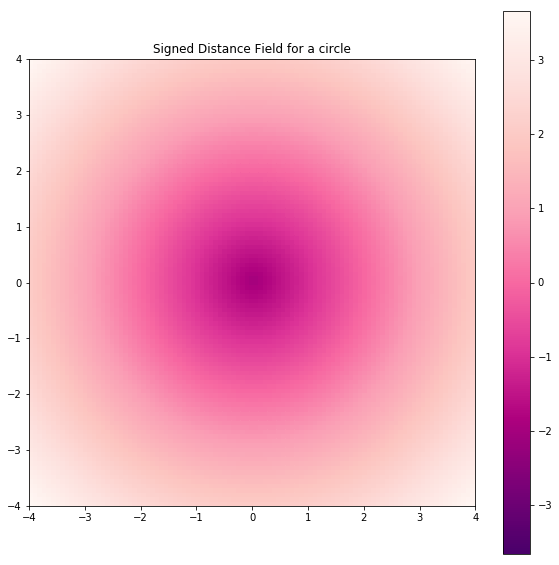

In [ ]:
circle = Circle(np.float_([0, 0]), 2)
circle.plot()

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x
    
    def plot(self, show=True):
        c_linecpace = np.linspace(-4, 4, 100)
        y, x = np.meshgrid(c_linecpace, c_linecpace)
        z = np.float_([[self.forward(np.float_([x_, y_])) 
                        for y_ in  c_linecpace] 
                        for x_ in c_linecpace])
        z = z[:-1, :-1]
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        fig, ax = plt.subplots(figsize=(10, 10))
        c = ax.pcolormesh(x, y, z, cmap='RdPu_r', vmin=z_min, vmax=z_max)
        plt.axis([x.min(), x.max(), y.min(), y.max()])
        if show:
            ax.set_aspect(aspect='equal')
            fig.colorbar(c, ax=ax)
            plt.title("Signed Distance Field for a figure during training")
            plt.show()
            
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


[[3.65685425 3.60000583 3.54375238 ... 3.54375238 3.60000583 3.65685425]
 [3.60000583 3.54257437 3.48573202 ... 3.48573202 3.54257437 3.60000583]
 [3.54375238 3.48573202 3.42829448 ... 3.42829448 3.48573202 3.54375238]
 ...
 [3.54375238 3.48573202 3.42829448 ... 3.42829448 3.48573202 3.54375238]
 [3.60000583 3.54257437 3.48573202 ... 3.48573202 3.54257437 3.60000583]
 [3.65685425 3.60000583 3.54375238 ... 3.54375238 3.60000583 3.65685425]]


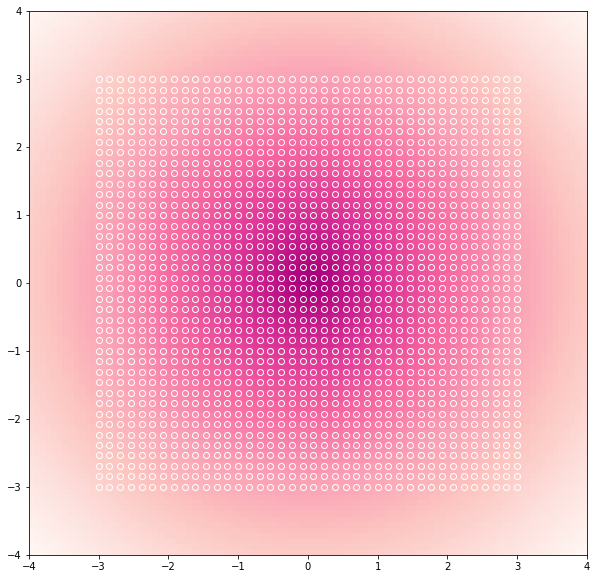

In [ ]:
points_train, sdf_train = circle.train_sample()

In [ ]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

Epoch: 0 Loss: 0.8158746361732483


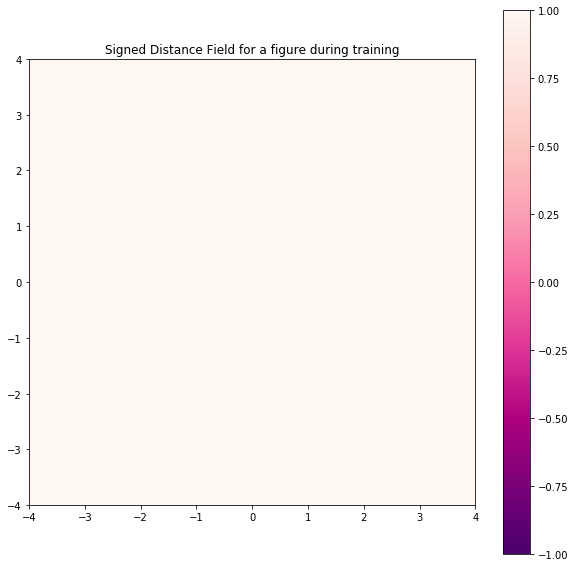

Epoch: 50 Loss: 0.8466583490371704


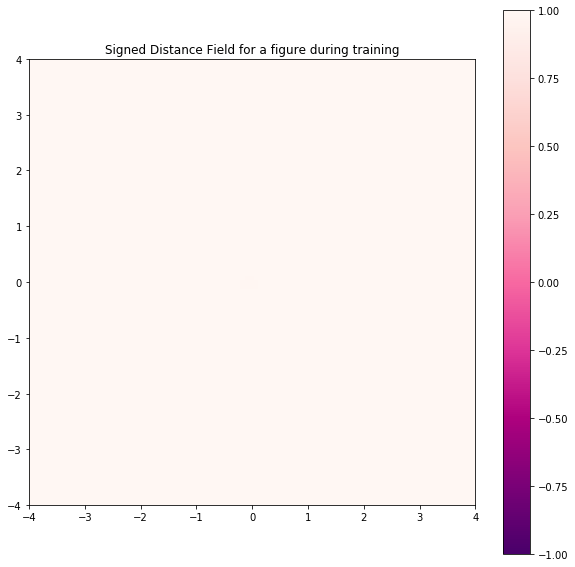

Epoch: 100 Loss: 0.8463438153266907


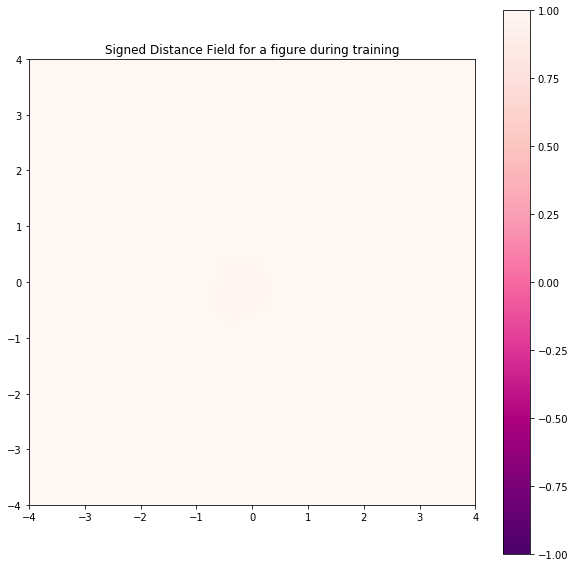

Epoch: 150 Loss: 0.8423988223075867


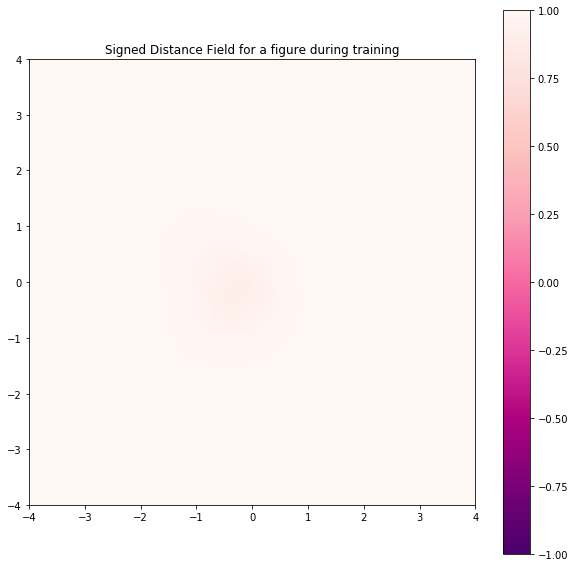

Epoch: 200 Loss: 0.3474680185317993


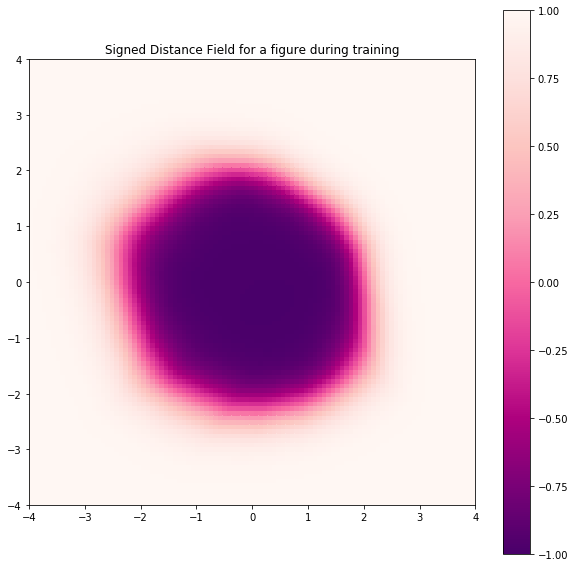

Epoch: 250 Loss: 0.35167205333709717


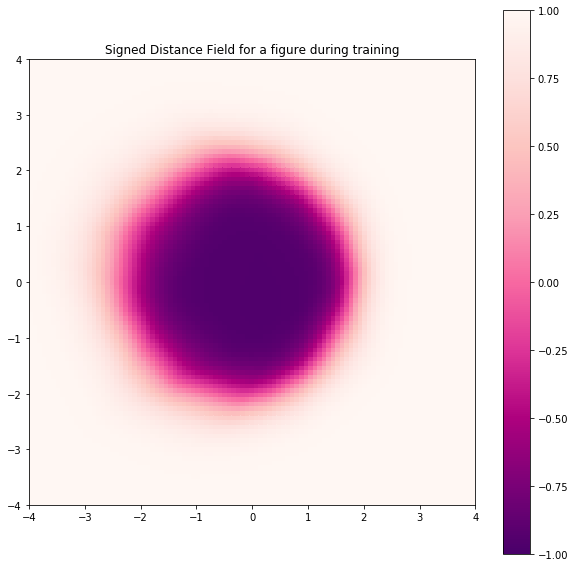

In [ ]:
net = Net()
epochs = 251
delta = 10
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        pred = pred.squeeze()
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    if (epoch % 50 == 0):
        print("Epoch:", epoch, "Loss:", total_loss.item())
        net.plot()

In [ ]:
class Mesh2D:
    def __init__(self, obj_dir):
        self.obj_dir = obj_dir
        self.sdf_step = 0
        self.mesh = None
    
    def create_mesh(self):
        self.mesh = kal.rep.TriangleMesh.from_obj(self.obj_dir)
    
    def sdf(self, points_tensor):
        self.create_mesh()
        sdf = kal.conversions.trianglemesh_to_sdf(self.mesh)
        self.sdf_step += 1
        if self.sdf_step % 100 == 0:
          print(self.sdf_step)
        return sdf(points_tensor).numpy()
        
    def plot(self, show=True):
        c_linecpace = np.linspace(0, 5000, 40)
        y, x = np.meshgrid(c_linecpace, c_linecpace)
        z = np.float_([[ self.sdf(torch.FloatTensor([[x_, y_, 0]]))[0] for y_ in  c_linecpace] for x_ in c_linecpace ])
        # print(z)
        z = z[:-1, :-1]
        z_min, z_max = -np.abs(z).max(), np.abs(z).max()
        fig, ax = plt.subplots(figsize=(10, 10))
        c = ax.pcolormesh(x, y, z, cmap='RdPu_r', vmin=z_min, vmax=z_max)
        plt.axis([x.min(), x.max(), y.min(), y.max()])
        if show:
            ax.set_aspect(aspect='equal')
            fig.colorbar(c, ax=ax)
            plt.title("Signed Distance Field for a circle")
            plt.show()
            
    def train_sample(self):
        points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(0, 5000, 100) 
                    for x_ in np.linspace(0, 5000, 100)])
        sdf_train = np.float_(list(map(circle.sdf, points_train)))

        self.plot(show=False)
        plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#FFFFFF")
        return points_train, sdf_train


In [ ]:
plane = Mesh2D('3dobjects/1_simplified.obj')
plane.plot()

In [ ]:
class SDFNet(nn.Module):
    def __init__(self, inner_dim=512, num_layers=8, dropout_rate=0.3): #dropout rate 0.2 was used in paper and 16-layer architecture could produce better results
        super(SDFNet, self).__init__()
        self.layers = nn.ModuleList()
        
        input_dim = 3
        
        for i in range(num_layers-1):
            self.layers.append(nn.Linear(input_dim, inner_dim))
            input_dim = inner_dim
        self.output = nn.Linear(inner_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x), inplace=True)
            x = self.dropout(x)
        
        x = self.tanh(self.output(x))
        return x 


In [ ]:
# import mesh_to_sdf 
from tqdm import tqdm_notebook as tqdm
import math


class MeshSDFSampler:
    def __init__(self, mesh):
        self.mesh = mesh
        self.correct_faces = {i:0 for i in range(len(mesh.faces))}
        self.correct_points = np.array([])
        self.correct_faces = {i:1 for i in range(len(mesh.faces))}
        self.sdf_step = 0

    def sample_points(self, n_points=10000):
        points = trimesh.sample.sample_surface(self.mesh, count=n_points)
        correct_points = []
        normals_for_points = []
        for i, point in enumerate(tqdm(points[0])):
            if self.correct_faces[points[1][i]] == 1:
                correct_points += [point]
                normals_for_points += [self.mesh.face_normals[points[1][i]]]
        self.correct_points = np.array(correct_points)
        self.normals_for_points = np.array(normals_for_points)
        return self.correct_points

    def compute_sdf(self, sigma=0.0025):
        noise = np.random.normal(0, sigma, self.correct_points.shape)
        noisy_points = self.correct_points + noise
        sdf = mesh_to_sdf.mesh_to_sdf(self.mesh, noisy_points)
        correct_mesh_points = []
        correct_sdf = []
        correct_normals = []
        for i, distance in enumerate(sdf):
            if math.isnan(distance):
                continue
            else:
                correct_mesh_points += [noisy_points[i]]
                correct_sdf += [sdf[i]]
                correct_normals += [self.normals_for_points[i]]
        return np.array(correct_mesh_points), np.array(correct_sdf), np.array(correct_normals)


# mesh = trimesh.load('3dobjects/1_simplified.obj')

# sampler = MeshSDFSampler(trimesh.load(mesh))
# points = sampler.sample_points(n_points=500000)
# noisy_points, sdf, normals = sampler.compute_sdf(sigma=1.0)

# i="_1"
# np.save(os.path.join('./', 'sdf'+str(i)+'.npy'), sdf)
# np.save(os.path.join('./', 'points'+str(i)+'.npy'), noisy_points,)


 Mesh to sdf works very fast, but this colab notebook is not compatible with the OpenGL and pyrender combination that is needed. I pre-generated the points and sdf on my system (Ubuntu 18.4, core i7 10Gen, Nvidia MX250) it took just a couple of seconds. 

*requirements*: mesh-to-sdf, pyrender==0.1.30, pyglet==1.4.0b1

After generating the points and sdf I stored them in a mounted google drive here.
But, sampling as shown in a class MeshSampler is a more logical approach to this task. While mesh_to_sdf librarty is fast, it samples points spread evenly near the surface of the figure. It can be nice, but the noisy points approach can make training converge faster due to the training data being focused arounf the mesh borders that we need to learn.

This samples is an attempt to sample the points around the shape, however the points are comming out imbalanced and training moover extremely poorely on such an imbalanced dataset. Fot this reason I used the mesh_to_sdf simple built in sampling and it worked just fine

In [ ]:
%ls sdf

points_1.npy  points_1_round.npy  sdf_1.npy  sdf_1_round.npy


In [ ]:
plane_mesh = np.load('./sdf/points_1_round.npy')
plane_sdf = np.load('./sdf/sdf_1_round.npy')
plane_sdf = np.expand_dims(plane_sdf,-1)

assert plane_sdf.ndim==2 and plane_sdf.shape[1]==1
assert plane_mesh.ndim==2 and plane_mesh.shape[1]==3

In [ ]:
print(len(plane_sdf))

500000


In [ ]:
class SDFData(Dataset):
    def __init__(self, points, sdf):
        self.points = points
        self.sdf = sdf

    def __getitem__(self, index):
        return self.points[index], self.sdf[index]

    def __len__(self):
        return self.points.shape[0]


def get_weights(labels):
    total = len(labels)
    weight_negative = float((labels>=0).sum())/total
    print(weight_negative)
    return [weight_negative if l<0 else 1-weight_negative for l in labels]

In [ ]:
batch_size = 16384
train_steps = 400
val_steps = 200

# random points for validation
val_fraction = 0.35

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFData(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFData(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

0.5472478911749856
0.5467938196074176


In [ ]:
print(len(train_dataset))

352365


In [ ]:
torch.cuda.is_available()

True

In the paper they use this variation of MSE:

$$ Loss(net(x, y), sdf(x, y)) = |clamp(net(x, y), \delta) - clamp(sdf(x, y), \delta)| $$

$clamp(x, \delta) = min(\delta, max(-\delta, x))$


In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [ ]:
model = SDFNet().cuda()

criterion = nn.MSELoss()
# criterion = RMSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# to clamp sdf values for both targets and model outputs
def clamp(delta, x):
    return torch.clamp(x, min=-delta, max=delta)

def mse(outputs, targets):
    return ((outputs - targets) ** 2).sum() #taking sum just to track the progress

In [ ]:
class SDFTrainer:
    def __init__(self, model, criterion, optimizer, delta=0.1, checkpoints_dir='checkpoints'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.delta = delta
        os.makedirs(checkpoints_dir, exist_ok=True)
        self.checkpoints_dir=checkpoints_dir
        
    def fit(self, train_loader, val_loader, epochs, save=False):
        best_val_mse = 1e6
        for epoch in range(epochs):
            self._train(train_loader, epoch)
            val_loss, val_mse = self._validate(val_loader)
            if val_mse<best_val_mse:
                best_val_mse = val_mse
                if save:
                    self.save_weights()  
    def save_weights(self, name='model.pth'):
        torch.save(self.model.state_dict(), os.path.join(self.checkpoints_dir, name))

    def load_weights(self, weights_path):
        self.model.load_state_dict(weights_path)
        
    def _validate(self, loader):
        self.model.eval()
        running_loss = []
        running_mse = []
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                loss = criterion(clamp(self.delta, outputs), clamp(self.delta, targets))
                
                running_loss.append(loss.item())
                running_mse.append(mse(outputs, targets).detach().cpu().numpy())
        
        mean_loss = np.mean(running_loss)
        mean_mse = np.mean(running_mse)
        
        print(f'val loss: {mean_loss:.5f}, val mse: {mean_mse:.5f}')
        return mean_loss, mean_mse
        
    def _train(self, loader, epoch):
        self.model.train()
        running_loss = []
        running_mse = []
        tq = tqdm(total=len(loader))
        tq.set_description('Epoch {}'.format(epoch))
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(clamp(delta, outputs), clamp(delta, targets))

            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            running_mse.append(mse(outputs, targets).detach().cpu().numpy())

            mean_loss = np.mean(running_loss)
            mean_mse = np.mean(running_mse)
                
            tq.update()
            tq.set_postfix(loss='{:.3f}'.format(mean_loss), mse = '{:.3f}'.format(mean_mse))            


In [ ]:
epochs = 16
delta = 0.05 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

val loss: 0.00001, val mse: 77.24551


val loss: 0.00001, val mse: 120.09351


val loss: 0.00001, val mse: 139.87917


val loss: 0.00001, val mse: 165.27762


val loss: 0.00001, val mse: 175.16754


val loss: 0.00001, val mse: 186.50079


val loss: 0.00001, val mse: 198.48369


val loss: 0.00001, val mse: 195.71852


val loss: 0.00001, val mse: 214.33043


val loss: 0.00001, val mse: 202.52129


val loss: 0.00001, val mse: 208.80969


val loss: 0.00001, val mse: 222.42148


val loss: 0.00001, val mse: 208.68910


val loss: 0.00001, val mse: 233.92238


val loss: 0.00001, val mse: 210.81566


val loss: 0.00001, val mse: 219.58125


In [ ]:
def plot_sdf(xyz, sdf, n_display=300000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-1, 1)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)

    plt.show()

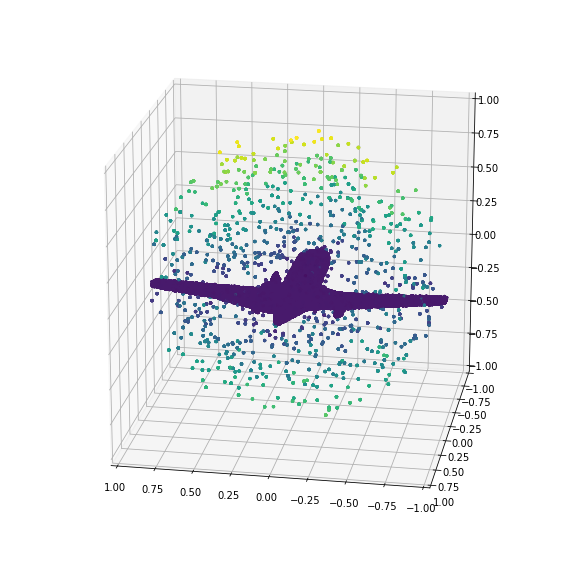

In [ ]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze())

In [ ]:
sdf_values = model(x.float().cuda()) # model predictions
sdf_values = sdf_values.detach().cpu().numpy()

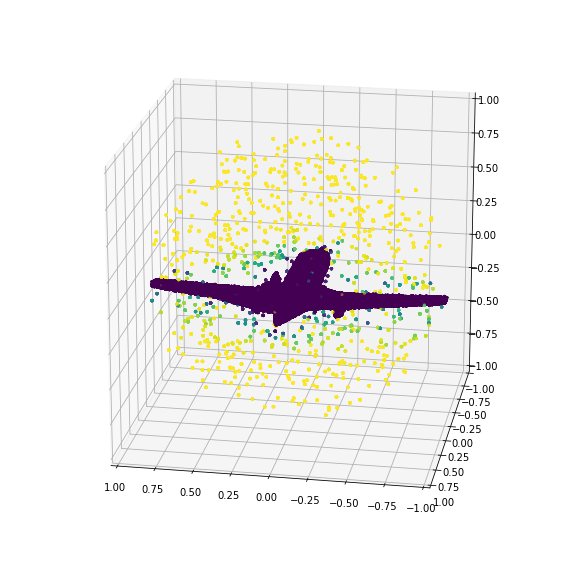

In [ ]:
plot_sdf(x.numpy(), sdf_values.squeeze())

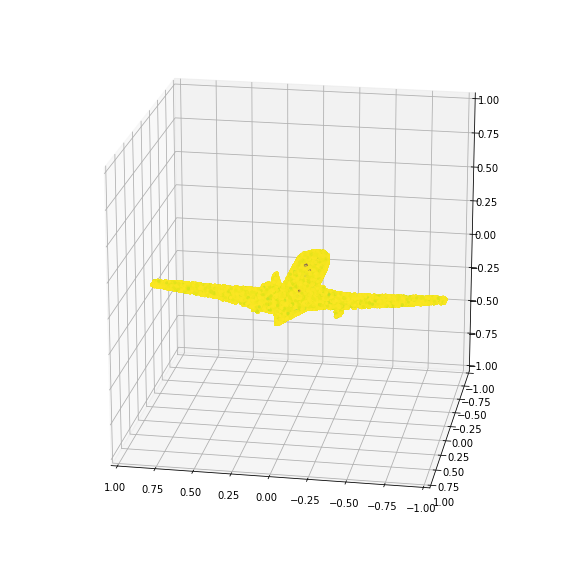

In [ ]:
ind = y.squeeze()<=0
plot_sdf(x[ind, :].numpy(), y[ind,:].squeeze())

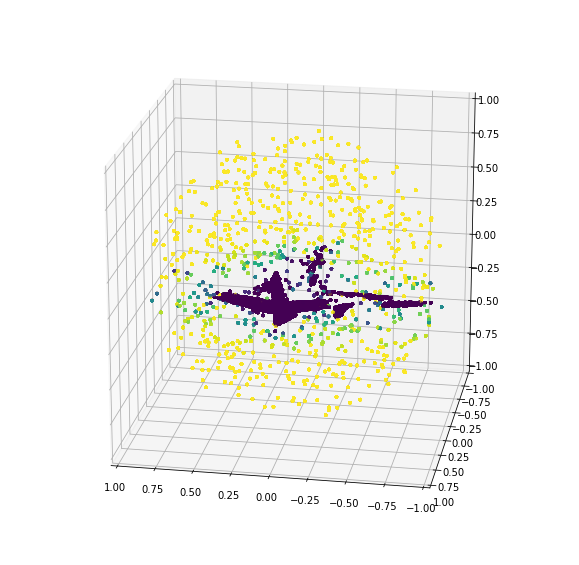

In [ ]:
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

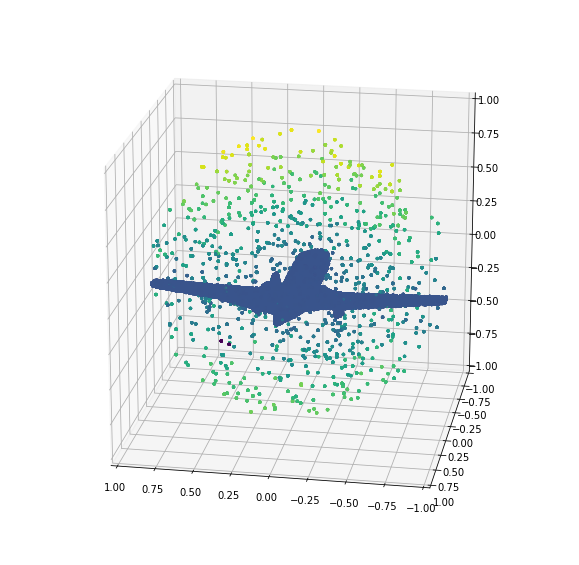

In [ ]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze())

val loss: 0.00001, val mse: 173.09592


val loss: 0.00001, val mse: 172.82024


val loss: 0.00001, val mse: 174.26740


val loss: 0.00001, val mse: 174.15092


val loss: 0.00001, val mse: 175.13860


val loss: 0.00001, val mse: 173.19269


val loss: 0.00001, val mse: 173.75427


val loss: 0.00001, val mse: 173.25639


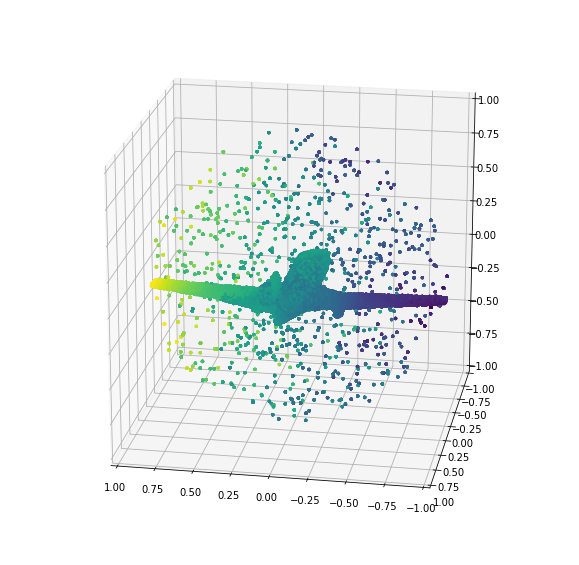

In [ ]:
model = SDFNet(inner_dim=512, num_layers=16, dropout_rate=0.2).cuda()

criterion = nn.MSELoss()
# criterion = RMSELoss()

lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 8
delta = 0.01 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

x, y = next(iter(val_loader))

sdf_values = model(x.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

val loss: 0.00049, val mse: 170.90839


val loss: 0.00049, val mse: 170.73311


val loss: 0.00049, val mse: 170.15289


val loss: 0.00049, val mse: 170.96535


val loss: 0.00049, val mse: 170.00880


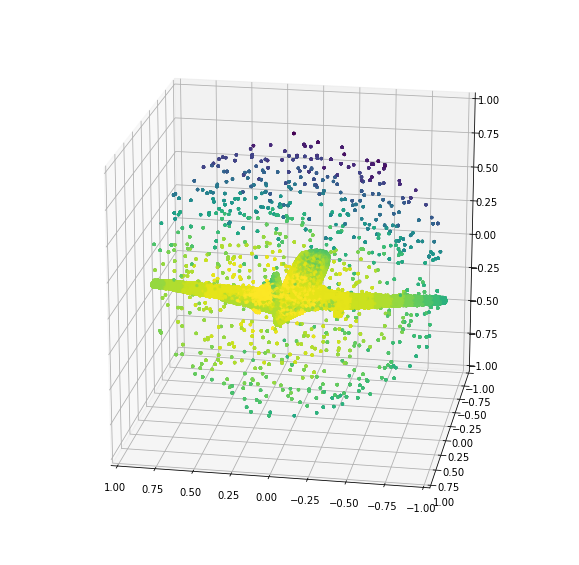

In [ ]:
model = SDFNet(inner_dim=512, num_layers=16, dropout_rate=0.2).cuda()

criterion = nn.MSELoss()
# criterion = RMSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 5
delta = 0.1 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

x, y = next(iter(val_loader))

sdf_values = model(x.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

summary(model, (512, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 512, 512]           2,048
           Dropout-2             [-1, 512, 512]               0
            Linear-3             [-1, 512, 512]         262,656
           Dropout-4             [-1, 512, 512]               0
            Linear-5             [-1, 512, 512]         262,656
           Dropout-6             [-1, 512, 512]               0
            Linear-7             [-1, 512, 512]         262,656
           Dropout-8             [-1, 512, 512]               0
            Linear-9             [-1, 512, 512]         262,656
          Dropout-10             [-1, 512, 512]               0
           Linear-11             [-1, 512, 512]         262,656
          Dropout-12             [-1, 512, 512]               0
           Linear-13             [-1, 512, 512]         262,656
          Dropout-14             [-1, 5

0.5478239893292467
0.5454194466081891


val loss: 0.00027, val mse: 104.96597


val loss: 0.00005, val mse: 14.66309


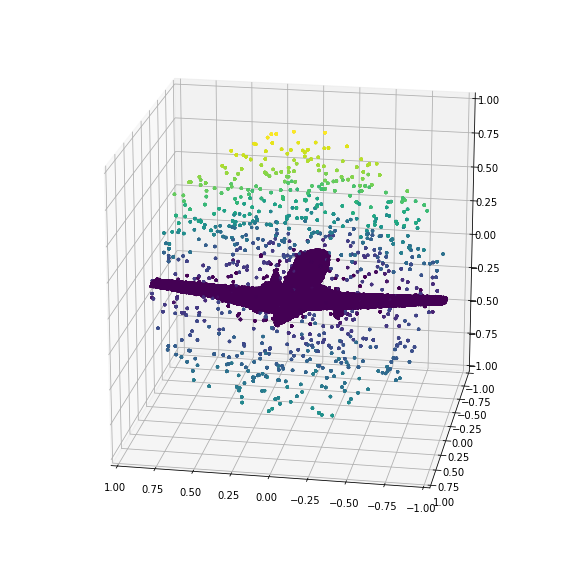

In [ ]:
batch_size = 16384
train_steps = 100
val_steps = 50

# random points for validation
val_fraction = 0.35

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFData(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFData(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

model = SDFNet(inner_dim=512, num_layers=8, dropout_rate=0.3).cuda()

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 2
delta = 0.1 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

x, y = next(iter(val_loader))

sdf_values = model(x.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

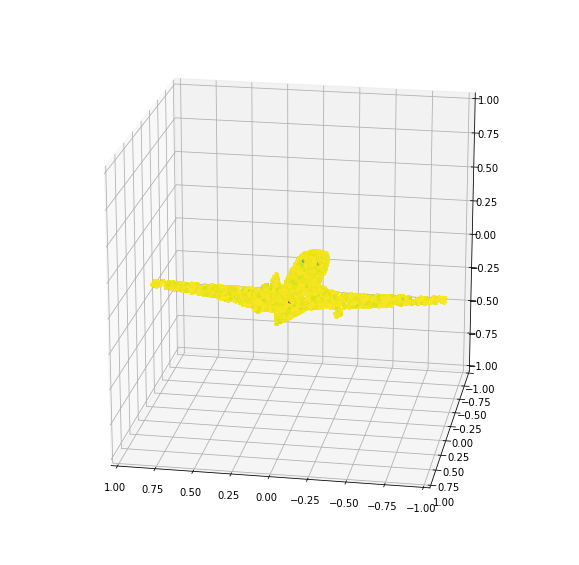

In [ ]:
ind = y.squeeze()<=-0.001
plot_sdf(x[ind, :].numpy(), y[ind,:].squeeze())

In [ ]:
%ls checkpoints/

model.pth


In [ ]:
model = SDFNet(inner_dim=512, num_layers=8, dropout_rate=0.3).cuda()
model.load_state_dict(torch.load("checkpoints/model.pth"))
model.eval()


SDFNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)

In [ ]:
random_point = torch.rand(300000,3)*2 -1

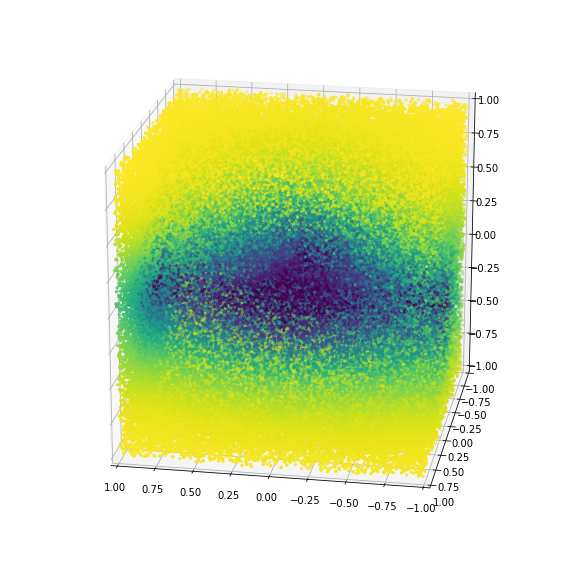

In [ ]:
sdf_values = model(random_point.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()>=0
plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

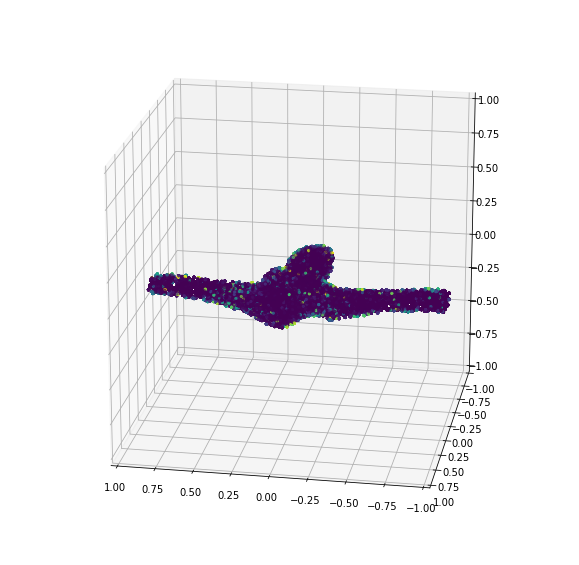

In [ ]:
ind = sdf_values.squeeze()<=0.01

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

In [ ]:
summary(model, (512, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 512, 512]           2,048
           Dropout-2             [-1, 512, 512]               0
            Linear-3             [-1, 512, 512]         262,656
           Dropout-4             [-1, 512, 512]               0
            Linear-5             [-1, 512, 512]         262,656
           Dropout-6             [-1, 512, 512]               0
            Linear-7             [-1, 512, 512]         262,656
           Dropout-8             [-1, 512, 512]               0
            Linear-9             [-1, 512, 512]         262,656
          Dropout-10             [-1, 512, 512]               0
           Linear-11             [-1, 512, 512]         262,656
          Dropout-12             [-1, 512, 512]               0
           Linear-13             [-1, 512, 512]         262,656
          Dropout-14             [-1, 5

In [ ]:
epochs = 16
delta = 0.1 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

val loss: 0.00001, val mse: 25.10943


val loss: 0.00001, val mse: 25.09759


val loss: 0.00001, val mse: 25.02578


val loss: 0.00001, val mse: 25.28507


val loss: 0.00001, val mse: 24.96155


val loss: 0.00001, val mse: 25.12914


val loss: 0.00001, val mse: 25.07739


val loss: 0.00001, val mse: 25.09902


val loss: 0.00001, val mse: 25.08930


val loss: 0.00001, val mse: 25.13539


val loss: 0.00001, val mse: 24.99791


val loss: 0.00001, val mse: 25.09283


val loss: 0.00001, val mse: 24.97677


val loss: 0.00001, val mse: 25.14058


val loss: 0.00001, val mse: 25.15757


val loss: 0.00001, val mse: 25.06565


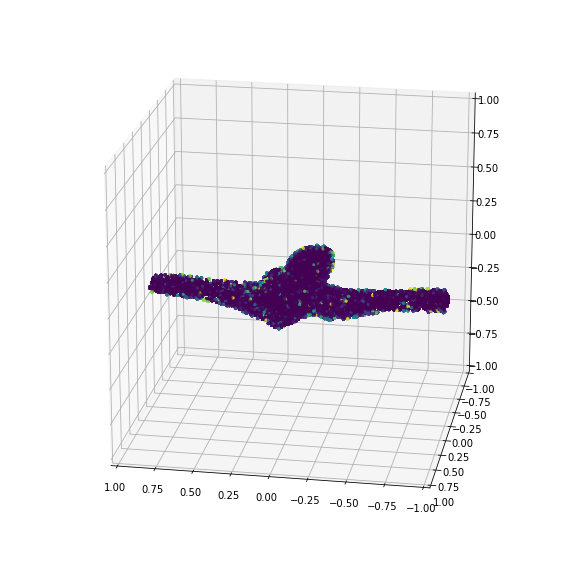

In [ ]:
model = SDFNet(inner_dim=512, num_layers=8, dropout_rate=0.3).cuda()
model.load_state_dict(torch.load("checkpoints/model.pth"))
model.eval()

random_point = torch.rand(300000,3)*2 -1
sdf_values = model(random_point.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()<=0.01

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

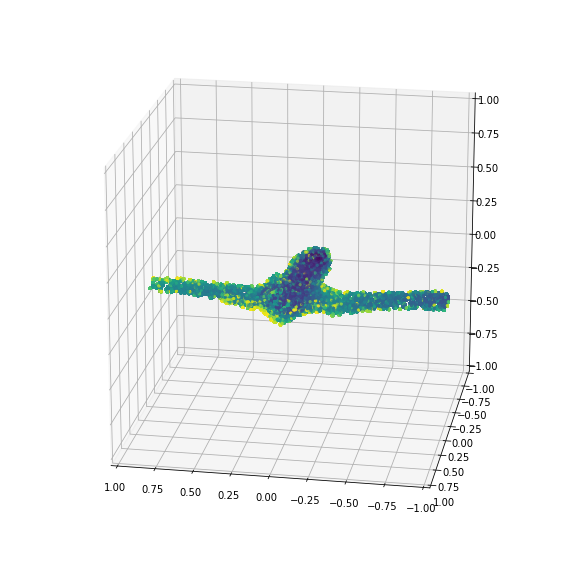

In [ ]:
ind = sdf_values.squeeze()<=0.00007

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

In [ ]:
batch_size = 16384
train_steps = 400
val_steps = 200

# random points for validation
val_fraction = 0.35

plane_mesh = np.load('./sdf/points_1_equally_distributed.npy')
plane_sdf = np.load('./sdf/sdf_1_equally_distributed.npy')
plane_sdf = np.expand_dims(plane_sdf,-1)

assert plane_sdf.ndim==2 and plane_sdf.shape[1]==1
assert plane_mesh.ndim==2 and plane_mesh.shape[1]==3

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFData(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFData(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

model = SDFNet(inner_dim=512, num_layers=8, dropout_rate=0.3).cuda()

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 8
delta = 0.1 #0.01 used in paper

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

x, y = next(iter(val_loader))

sdf_values = model(x.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())

0.9918278873875217
0.992098967620994


val loss: 0.00015, val mse: 642.28735


val loss: 0.00008, val mse: 400.89978


val loss: 0.00007, val mse: 288.32266


val loss: 0.00005, val mse: 244.93597


val loss: 0.00004, val mse: 255.17300


val loss: 0.00004, val mse: 236.98836


KeyboardInterrupt: ignored

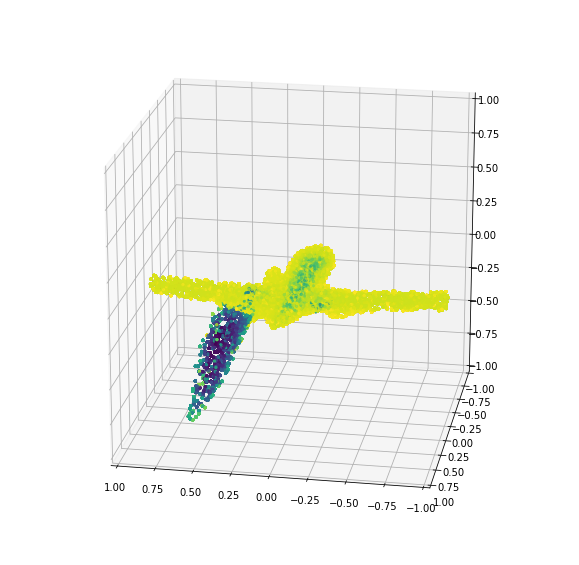

In [ ]:
model = SDFNet(inner_dim=512, num_layers=8, dropout_rate=0.3).cuda()
model.load_state_dict(torch.load("checkpoints/model.pth"))
model.eval()

random_point = torch.rand(300000,3)*2 -1
sdf_values = model(random_point.float().cuda()) # model predictions

sdf_values = sdf_values.detach().cpu().numpy()
ind = sdf_values.squeeze()<=0.01

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

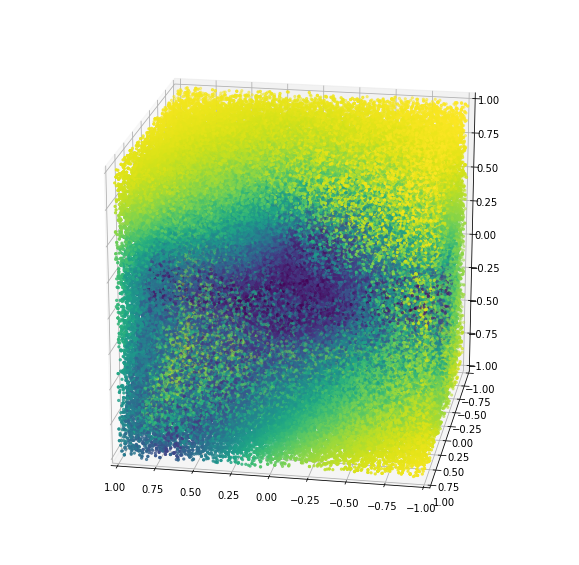

In [ ]:
ind = sdf_values.squeeze()>0

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

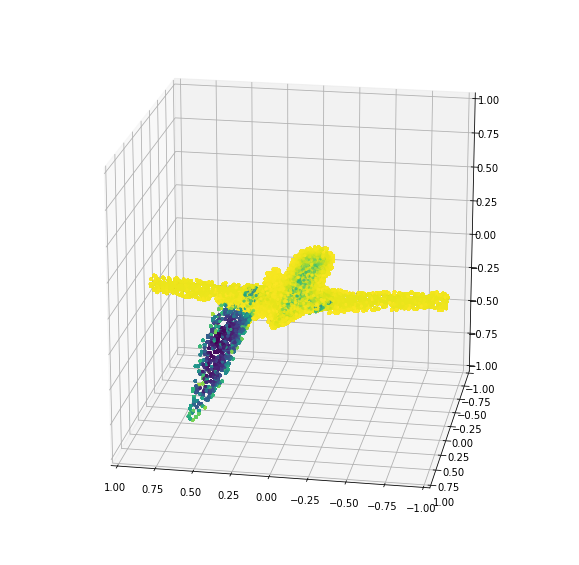

In [ ]:
ind = sdf_values.squeeze()<=0

plot_sdf(random_point.numpy()[ind, :], sdf_values[ind].squeeze())

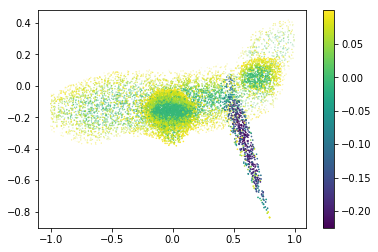

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ind = sdf_values.squeeze()<=0.1

plane_mesh = random_point.numpy()[ind, :]
plane_sdf = sdf_values[ind].squeeze()
x=plane_mesh[:,2]
y=plane_mesh[:,1]
z=plane_mesh[:,0]

delta = 0.9
offset = -0.58#-0.1
colors=plane_sdf
ind = np.logical_and(-delta < plane_sdf , plane_sdf <= delta)
x=x[ind]
y=y[ind]
z=z[ind]
colors=colors[ind]

#ind = plane_sdf < 0.2 


plt.scatter(x, y,z, c=colors, #s=sizes, alpha=0.3,
            cmap='viridis')
plt.colorbar();  # show color scale